In [1]:
## Import necessary libraries - should work mostly from BCI_analysis + matplotlib + numpy
import BCI_analysis
from BCI_analysis.pipeline import pipeline_regression
import importlib
importlib.reload(pipeline_regression)
importlib.reload(BCI_analysis)
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

No module named 'cellpose'
cannot use anatomical mode, but otherwise suite2p will run normally


In [29]:
data_dict[session]['dff_sessionwise'].shape

(1152, 59531)

In [32]:
(data_dict[session]['dff_sessionwise'] - np.nanmean(data_dict[session]['dff_sessionwise'],1)[:,np.newaxis])/np.nanstd(data_dict[session]['dff_sessionwise'],1)[:,np.newaxis]


array([[-1.7070436e-01, -8.7188184e-01, -8.8424718e-01, ...,
        -4.8431906e-01, -6.4936891e-02, -7.1521902e-01],
       [ 2.7224412e+00,  3.4310715e+00,  3.3477914e+00, ...,
         2.3110642e+00,  2.5481637e+00,  1.5017205e+00],
       [-2.1213669e-01, -6.0119128e-01, -7.9440868e-01, ...,
         3.9135182e-01,  1.2995236e+00,  9.7297221e-01],
       ...,
       [-7.0612371e-01, -2.3885192e-01, -5.9243876e-01, ...,
         5.3231321e-02,  1.0652388e-03, -1.2503629e+00],
       [-2.9640672e-01,  9.4405842e-01,  1.8627110e+00, ...,
        -1.2503821e-01,  7.3655754e-01, -4.5423743e-01],
       [-1.1692950e+00, -1.0932826e+00,  7.1694419e-02, ...,
        -1.8452881e-02, -4.7742829e-01, -9.1144365e-01]], dtype=float32)

In [1]:
#%% suggest neurons for next session based on previous sessions
import os
import BCI_analysis
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from scipy.io import savemat
from scipy.stats import zscore
import shutil
import matplotlib.pyplot as plt

use_scalar_f0 = False

sessionwise_base_dir = '/home/jupyter/bucket/Data/Calcium_imaging/sessionwise_tba'
s2p_base_dir = '/home/jupyter/bucket/Data/Calcium_imaging/suite2p/Bergamo-2P-Photostim'
raw_scanimage_dir = '/home/jupyter/bucket/Data/Calcium_imaging/raw/Bergamo-2P-Photostim'
bpod_path = '/home/jupyter/bucket/Data/Behavior/BCI_exported/Bergamo-2P-Photostim/'

#next_session_dir = '/home/jupyter/bucket/Data/Calcium_imaging/next_session'

maximum_decrease_in_f0 = .25 # if decreases above this amount will be thrown out
step_back = 60
step_forward = 300

# 2 neuron stuff
# subject = 'BCI_41'
# fov = 'FOV_02'
# subject = 'BCI_42'
# fov = 'FOV_04'
# subject = 'BCI_43'
# fov = 'FOV_02'
# 2 neuron stuff

subject = 'BCI_60'
fov = 'FOV_01'
use_red_channel = False
zscore_dff = False
multi_session_dict = {'mouse':[],
                     'session':[],
                      'mat_idx':[],
                     'cn':[],
                      'cn_previous':[],
                     'DLC_aligned':[],
                     'F':[],
                     'trial_end_frames':[],
                     'F_original':[],
                     'F_original_pre_task':[],
                     'trial_start_original':[],
                     'trial_start_original_pre_task':[],
                     'reward_original':[],
                     'reward_original_pre_task':[],
                     'sampling_rate':[]}

next_session_dir = '/home/jupyter/bucket/Data/Calcium_imaging/next_session/{}-{}/'.format(subject, fov)
files = os.listdir(os.path.join(sessionwise_base_dir,subject))
data_dict = {}
sessions = []
stat = np.load(os.path.join(s2p_base_dir,subject,fov,'stat.npy'),allow_pickle=True).tolist()
stat_rest = np.load(os.path.join(s2p_base_dir,subject,fov,'stat_rest.npy'),allow_pickle=True).tolist()
for file in files: ### NOT ALL FILES?? - 
    
    if fov in file:
        session = file[len(subject)+1:-1*(len(fov)+5)]
        sessions.append(session)
        data_dict[session] = BCI_analysis.io_python.read_sessionwise_npy(os.path.join(sessionwise_base_dir,subject,file))
        F0 = np.load(os.path.join(s2p_base_dir,subject,fov,session,'F0.npy'))
        if use_red_channel:
            F = np.load(os.path.join(s2p_base_dir,subject,fov,session,'F_chan2.npy'))
            data_dict[session]['F_sessionwise'] =  F
            dff = (F-F0)/F0
            data_dict[session]['dff_sessionwise'] = dff
            
        
        if any(np.nanmean(F0/np.nanmedian(F0[:,:10000],1)[:,np.newaxis],0)<1-maximum_decrease_in_f0):
            throw_out_idx = np.where(np.nanmean(F0/np.nanmedian(F0[:,:10000],1)[:,np.newaxis],0)<1-maximum_decrease_in_f0)[0][0]
        else:
            throw_out_idx = data_dict[session]['dff_sessionwise'].shape[1]
        throw_out_idx = data_dict[session]['dff_sessionwise'].shape[1]    
        print('{}% discarded due to f0 rundown'.format(round(100*(1-(throw_out_idx/data_dict[session]['dff_sessionwise'].shape[1])))))
        data_dict[session]['F_sessionwise'] = data_dict[session]['F_sessionwise'][:,:throw_out_idx]
        data_dict[session]['dff_sessionwise'] = data_dict[session]['dff_sessionwise'][:,:throw_out_idx]
        if use_scalar_f0:
            data_dict[session]['dff_sessionwise'] = (data_dict[session]['F_sessionwise']-data_dict[session]['f0_scalar'][:,np.newaxis])/data_dict[session]['f0_scalar'][:,np.newaxis]
        #data_dict[session]['photon_counts']=np.load(os.path.join(s2p_base_dir,subject,fov,session,'photon_counts.npy'),allow_pickle=True).tolist()
        data_dict[session]['signal_to_noise_trace'] = data_dict[session]['dff_sessionwise']*data_dict[session]['photon_counts']['dprime_1dFF'][:,np.newaxis]
        print(file)
        uniquecns = np.unique(np.asarray(data_dict[session]['cn'])[(np.asarray(data_dict[session]['cn'])==None) ==False])
        
        if zscore_dff:
            data_dict[session]['dff_sessionwise'] = (data_dict[session]['dff_sessionwise'] - np.nanmean(data_dict[session]['dff_sessionwise'],1)[:,np.newaxis])/np.nanstd(data_dict[session]['dff_sessionwise'],1)[:,np.newaxis]
            
        
        cn_prev = None
        if len(uniquecns)==2:
            median_index = []
            for ucn in uniquecns:
                median_index.append(np.nanmedian(np.where(np.asarray(data_dict[session]['cn'])==ucn)[0]))
            uniquecns = uniquecns[np.argsort(median_index)] # now they are ordered
            cn_prev = uniquecns[0]  
            #cn = uniquecns[1]
            
            closed_loop_indices_needed = (np.asarray(data_dict[session]['cn']) == None) == False
            closed_loop_indices = np.asarray(data_dict[session]['cn'])[closed_loop_indices_needed]==cn_prev
            data_dict[session]['F_trialwise_closed_loop_previous_CN'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['F_sessionwise'],
                                                                                                            data_dict[session]['all_si_filenames'],
                                                                                                            data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                            data_dict[session]['all_si_frame_nums'],
                                                                                                            data_dict[session]['sampling_rate'],
                                                                                                            'go_cue', # relative to what (go_cue / reward)
                                                                                                            data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                            data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                            max_frames=None,
                                                                                                            frames_after=step_forward,
                                                                                                            frames_before=step_back)
            data_dict[session]['dff_trialwise_closed_loop_previous_CN'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['dff_sessionwise'],
                                                                                                            data_dict[session]['all_si_filenames'],
                                                                                                            data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                            data_dict[session]['all_si_frame_nums'],
                                                                                                            data_dict[session]['sampling_rate'],
                                                                                                            'go_cue', # relative to what (go_cue / reward)
                                                                                                            data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                            data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                            max_frames=None,
                                                                                                            frames_after=step_forward,
                                                                                                            frames_before=step_back)
            data_dict[session]['F_trialwise_reward_closed_loop_previous_CN'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['F_sessionwise'],
                                                                                                            data_dict[session]['all_si_filenames'],
                                                                                                            data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                            data_dict[session]['all_si_frame_nums'],
                                                                                                            data_dict[session]['sampling_rate'],
                                                                                                            'reward', # relative to what (go_cue / reward)
                                                                                                            data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                            data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                            max_frames=None,
                                                                                                            frames_after=step_forward,
                                                                                                            frames_before=step_back)
            data_dict[session]['dff_trialwise_reward_closed_loop_previous_CN'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['dff_sessionwise'],
                                                                                                            data_dict[session]['all_si_filenames'],
                                                                                                            data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                            data_dict[session]['all_si_frame_nums'],
                                                                                                            data_dict[session]['sampling_rate'],
                                                                                                            'reward', # relative to what (go_cue / reward)
                                                                                                            data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                            data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                            max_frames=None,
                                                                                                            frames_after=step_forward,
                                                                                                            frames_before=step_back)
            
            data_dict[session]['go_cue_times_previous_CN'] = data_dict[session]['go_cue_times'][closed_loop_indices]
            data_dict[session]['reward_times_previous_CN'] = data_dict[session]['reward_times'][closed_loop_indices]
            data_dict[session]['scanimage_filenames_previous_CN'] = data_dict[session]['scanimage_filenames'][closed_loop_indices],
            data_dict[session]['lick_times_previous_CN'] = data_dict[session]['lick_times'][closed_loop_indices]
            data_dict[session]['hit_previous_CN'] = data_dict[session]['hit'][closed_loop_indices]
            data_dict[session]['threshold_crossing_times_previous_CN'] = data_dict[session]['threshold_crossing_times'][closed_loop_indices]
            data_dict[session]['zaber_move_forward_previous_CN'] = data_dict[session]['zaber_move_forward'][closed_loop_indices]
            
            
        elif len(uniquecns)>2:
            print('3 CNs in a single session!!!')
            
        start_frame_of_closed_loop = None
        if len(uniquecns)>0:
            cn = uniquecns[-1]
            
            
            closed_loop_indices_needed = (np.asarray(data_dict[session]['cn']) == None) == False
            closed_loop_indices = np.asarray(data_dict[session]['cn'])[closed_loop_indices_needed]==cn
            
            
            first_closed_loop_trial = np.where(closed_loop_indices)[0][0]
            start_frame_of_closed_loop = np.sum(np.asarray(data_dict[session]['all_si_frame_nums'])[:np.where(np.asarray(data_dict[session]['all_si_filenames']) == data_dict[session]['closed_loop_filenames'][first_closed_loop_trial])[0][0]])
            
            data_dict[session]['F_trialwise_closed_loop'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['F_sessionwise'],
                                                                                                            data_dict[session]['all_si_filenames'],
                                                                                                            data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                            data_dict[session]['all_si_frame_nums'],
                                                                                                            data_dict[session]['sampling_rate'],
                                                                                                            'go_cue', # relative to what (go_cue / reward)
                                                                                                            data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                            data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                            max_frames=None,
                                                                                                            frames_after=step_forward,
                                                                                                            frames_before=step_back)
            data_dict[session]['dff_trialwise_closed_loop'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['dff_sessionwise'],
                                                                                                            data_dict[session]['all_si_filenames'],
                                                                                                            data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                            data_dict[session]['all_si_frame_nums'],
                                                                                                            data_dict[session]['sampling_rate'],
                                                                                                            'go_cue', # relative to what (go_cue / reward)
                                                                                                            data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                            data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                            max_frames=None,
                                                                                                            frames_after=step_forward,
                                                                                                            frames_before=step_back)
            data_dict[session]['F_trialwise_reward_closed_loop'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['F_sessionwise'],
                                                                                                            data_dict[session]['all_si_filenames'],
                                                                                                            data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                            data_dict[session]['all_si_frame_nums'],
                                                                                                            data_dict[session]['sampling_rate'],
                                                                                                            'reward', # relative to what (go_cue / reward)
                                                                                                            data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                            data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                            max_frames=None,
                                                                                                            frames_after=step_forward,
                                                                                                            frames_before=step_back)
            data_dict[session]['dff_trialwise_reward_closed_loop'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['dff_sessionwise'],
                                                                                                            data_dict[session]['all_si_filenames'],
                                                                                                            data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                            data_dict[session]['all_si_frame_nums'],
                                                                                                            data_dict[session]['sampling_rate'],
                                                                                                            'reward', # relative to what (go_cue / reward)
                                                                                                            data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                            data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                            max_frames=None,
                                                                                                            frames_after=step_forward,
                                                                                                            frames_before=step_back)
            data_dict[session]['go_cue_times'] = data_dict[session]['go_cue_times'][closed_loop_indices]
            data_dict[session]['reward_times'] = data_dict[session]['reward_times'][closed_loop_indices]
            data_dict[session]['scanimage_filenames'] = data_dict[session]['scanimage_filenames'][closed_loop_indices]
            data_dict[session]['lick_times'] = data_dict[session]['lick_times'][closed_loop_indices]
            data_dict[session]['hit'] = data_dict[session]['hit'][closed_loop_indices]
            data_dict[session]['threshold_crossing_times'] = data_dict[session]['threshold_crossing_times'][closed_loop_indices]
            data_dict[session]['zaber_move_forward'] = data_dict[session]['zaber_move_forward'][closed_loop_indices]
            
            
            
            
            
            
            
            data_dict[session]['time_since_trial_start'] = np.arange(-step_back,step_forward,1)/data_dict[session]['sampling_rate']
            
        end_of_spont_idx = np.sum(np.asarray(data_dict[session]['all_si_frame_nums'])[:np.where(np.asarray(data_dict[session]['all_si_filenames']) == data_dict[session]['closed_loop_filenames'][0])[0][0]])
        multi_session_dict['mouse'].append(subject)
        multi_session_dict['session'].append(session)
        multi_session_dict['cn'].append(cn)
        multi_session_dict['cn_previous'].append(cn_prev)
        multi_session_dict['mat_idx'].append(None)
        multi_session_dict['DLC_aligned'].append(None)
        multi_session_dict['F'].append(None)
        multi_session_dict['trial_end_frames'].append(None)
        multi_session_dict['F_original'].append(data_dict[session]['dff_sessionwise'][:,start_frame_of_closed_loop:]) #????
        multi_session_dict['F_original_pre_task'].append(data_dict[session]['dff_sessionwise'][:,end_of_spont_idx:start_frame_of_closed_loop]) #??????
        multi_session_dict['sampling_rate'].append(data_dict[session]['sampling_rate'])
        
        trial_start_trace = np.zeros(multi_session_dict['F_original'][-1].shape[1])
        indices = np.cumsum(np.asarray(data_dict[session]['all_si_frame_nums']))
        indices = indices[indices>=start_frame_of_closed_loop]
        indices -= start_frame_of_closed_loop
        trial_start_trace[indices[:-1]] = 1
        multi_session_dict['trial_start_original'].append(trial_start_trace)
        
        trial_start_trace = np.zeros(multi_session_dict['F_original_pre_task'][-1].shape[1])
        indices = np.cumsum(np.asarray(data_dict[session]['all_si_frame_nums']))
        indices = indices[(indices<=start_frame_of_closed_loop) & (indices>=end_of_spont_idx)]
        indices -= end_of_spont_idx
        trial_start_trace[indices[:-1]] = 1
        multi_session_dict['trial_start_original_pre_task'].append(trial_start_trace)

        
        
#         trial_start_trace = np.zeros(multi_session_dict['F_original'][-1].shape[1])
#         indices = np.cumsum(np.asarray(data_dict[session]['all_si_frame_nums']))
#         indices = indices[indices>=start_frame_of_closed_loop]
#         indices -= start_frame_of_closed_loop
#         trial_start_trace[indices[:-1]] = 1
#         multi_session_dict['trial_start_original'].append(trial_start_trace)
        
        
#         'reward_original'
        
#         'reward_original_pre_task'
        
        
        # behavior_fname = os.path.join(bpod_path,subject, f"{session}-bpod_zaber.npy")
        # behavior_dict= np.load(behavior_fname,allow_pickle = True).tolist()
        # asdsad
        # data_dict['outputChannelsFunctions'] = behavior_dict['scanimage_roi_outputChannelsFunctions'][int(len(behavior_dict['go_cue_times'])/2)][0]
        # if 'anticorrelate' in data_dict['outputChannelsFunctions']:
        #     data_dict['training_type'] = 'anticorrelate'
        # else:
        #     data_dict['training_type'] = 'correlate'
        # del behavior_dict
        
        
        
        # if len(data_dict.keys())>3:
        #     break
        

        #%
        #%
sessions = np.sort(list(data_dict.keys()))
cn_list = []
for session in sessions:
    try:
        toadd = None
        i_ = len(data_dict[session]['cn'])-1
        while toadd is None:
            try:
                toadd = np.asarray(data_dict[session]['cn'])[i_]
            except:
                pass
            i_-=1
        #cn_list.append(np.unique(np.asarray(data_dict[session]['cn'])[np.asarray(data_dict[session]['cn'])!=None])) # assuming that the CN is not changing
        cn_list.append(toadd)
        print(toadd)
    except: 
        pass
    #%
#cn_list = np.unique(cn_list)
#%


No module named 'cellpose'
cannot use anatomical mode, but otherwise suite2p will run normally


OSError: [Errno 5] Input/output error: '/home/jupyter/bucket/Data/Calcium_imaging/sessionwise_tba/BCI_60'

In [47]:
indices

array([    0,   225,   449,   673,   739,   964,  1188,  1425,  1649,
        1873,  2180,  2338,  2562,  2786,  3044,  3322,  3546,  3696,
        3812,  4032,  4239,  4501,  4725,  4949,  5173,  5397,  5621,
        5845,  5976,  6200,  6424,  6648,  6872,  6991,  7215,  7439,
        7663,  7887,  8111,  8335,  8560,  8784,  9008,  9306,  9436,
        9704,  9853, 10077, 10162, 10386, 10610, 10900, 11124, 11348,
       11547, 11689, 11913, 12127, 12351, 12674, 12808, 13000, 13193,
       13386, 13515, 13704, 13917, 14120, 14510, 14608, 14740, 14870,
       15019])

In [ ]:
# bootstrapping of amplitudes 
#a
from sklearn.utils import resample
plot_amplitudes = True
max_p = .01
n_bootstrap = 1000
step_back = 60 #baseline before trial start (in frames)
step_forward = 300 #integration time after trial start (frames)
trace_time = np.arange(-step_back,step_forward)/20
# check if CNs are really increasing it's activity - who are the other cells that increase their activity
multi_session_dict['F_trialwise'] = [] #time x neuron x trial
multi_session_dict['F_trialwise_pre_training'] = [] #time x neuron x trial
multi_session_dict['F_rewardwise'] = [] #time x neuron x trial
multi_session_dict['F_rewardwise_pre_training'] = [] #time x neuron x trial
multi_session_dict['amplitude'] = []
multi_session_dict['amplitude_pre_training'] = []
multi_session_dict['previous_amplitude'] = []
multi_session_dict['delta_amplitude'] = []
multi_session_dict['delta_amplitude_pre_training'] = []
multi_session_dict['delta_amplitude_same_day'] = []
multi_session_dict['p_increase'] = []
multi_session_dict['p_decrease'] = []


yesterday_tuning_all = []
today_tuning_all = []
pretask_tuning_all = []
yesterday_tuning_all_cn = []
today_tuning_all_cn = []
pretask_tuning_all_cn = []
yesterday_tuning_all_prev_cn = []
today_tuning_all_prev_cn = []
pretask_tuning_all_prev_cn = []


for session_i,session in enumerate(multi_session_dict['session']):
    # trial_start_trace = np.zeros(multi_session_dict['F'][session_i].shape[1])
    # trial_start_trace[np.concatenate([[0],multi_session_dict['trial_end_frames'][session_i][:-1]])] = 1
    trial_start_trace = multi_session_dict['trial_start_original'][session_i]
    F_trialwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
                                                                            trial_start_trace,
                                                                            max_frames=None,
                                                                            frames_after=step_forward, 
                                                                            frames_before=step_back,
                                                                            include_next_trial=True)
    
    
    multi_session_dict['F_trialwise'].append(F_trialwise)
    
    F_trialwise_pre_training = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original_pre_task'][session_i],
                                                                            multi_session_dict['trial_start_original_pre_task'][session_i],
                                                                            max_frames=None,
                                                                            frames_after=step_forward, 
                                                                            frames_before=step_back,
                                                                            include_next_trial=True)
    
    multi_session_dict['F_trialwise_pre_training'].append(F_trialwise_pre_training)
    try:
        multi_session_dict['F_rewardwise_pre_training'].append(data_dict[session]['dff_trialwise_reward_closed_loop_previous_CN'] )
    except:
        multi_session_dict['F_rewardwise_pre_training'].append(F_trialwise_pre_training)
    multi_session_dict['F_rewardwise'].append(data_dict[session]['dff_trialwise_reward_closed_loop'] )
    
    if session_i >0:
        if multi_session_dict['F_original'][session_i].shape[0] == multi_session_dict['F_original'][session_i-1].shape[0]: #there is a previous session
           
            now_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i][:step_back,:,1:],0))
            now_amplitudes_pre_training = (np.nanmean(multi_session_dict['F_trialwise_pre_training'][session_i][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise_pre_training'][session_i][:step_back,:,1:],0))
            prev_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i-1][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i-1][:step_back,:,1:],0))
            real_deltas = np.nanmean(now_amplitudes,1)-np.nanmean(prev_amplitudes,1)
            real_deltas_prev = np.nanmean(now_amplitudes_pre_training,1)-np.nanmean(prev_amplitudes,1)
            cn = multi_session_dict['cn'][session_i]
            prev_cn = multi_session_dict['cn'][session_i-1]

            
            prev_mean_amplitude_bootstrap_list = []
            now_mean_amplitude_bootstrap_list = []

            for bootstrap_i in range(n_bootstrap):
                now_indices = resample(np.arange(now_amplitudes.shape[1]))
                now_mean_amplitude_bootstrap_list.append(np.mean(now_amplitudes[:,now_indices],1))
                prev_indices = resample(np.arange(prev_amplitudes.shape[1]))
                prev_mean_amplitude_bootstrap_list.append(np.mean(prev_amplitudes[:,prev_indices],1))
            now_mean_amplitude_bootstrap_list = np.asarray(now_mean_amplitude_bootstrap_list)
            prev_mean_amplitude_bootstrap_list = np.asarray(prev_mean_amplitude_bootstrap_list)
            delta_amplitudes_bootstrap = now_mean_amplitude_bootstrap_list-prev_mean_amplitude_bootstrap_list
            delta_sd = np.std(delta_amplitudes_bootstrap,0)


            cell_order = np.argsort(real_deltas)
            significantly_increasing_indices = 1-np.nanmean(delta_amplitudes_bootstrap>0,0)[cell_order]<max_p
            significantly_decreasing_indices = 1-np.nanmean(delta_amplitudes_bootstrap<0,0)[cell_order]<max_p
            
            multi_session_dict['delta_amplitude'].append(real_deltas)
            multi_session_dict['p_increase'].append(1-np.nanmean(delta_amplitudes_bootstrap>0,0))
            multi_session_dict['p_decrease'].append(1-np.nanmean(delta_amplitudes_bootstrap<0,0))
            multi_session_dict['amplitude'].append(np.nanmean(now_amplitudes,1))
            multi_session_dict['previous_amplitude'].append(np.nanmean(prev_amplitudes,1))
            
            multi_session_dict['amplitude_pre_training'].append(np.nanmean(now_amplitudes_pre_training,1))
            multi_session_dict['delta_amplitude_pre_training'].append(real_deltas_prev)
            multi_session_dict['delta_amplitude_same_day'].append(np.nanmean(now_amplitudes,1)-np.nanmean(now_amplitudes_pre_training,1))
            
            yesterday_tuning_all.append(np.nanmean(prev_amplitudes,1))
            today_tuning_all.append(np.nanmean(now_amplitudes,1))
            pretask_tuning_all.append(np.nanmean(now_amplitudes_pre_training,1))
            yesterday_tuning_all_cn.append(np.nanmean(prev_amplitudes,1)[cn])
            today_tuning_all_cn.append(np.nanmean(now_amplitudes,1)[cn])
            pretask_tuning_all_cn.append(np.nanmean(now_amplitudes_pre_training,1)[cn])
            
            yesterday_tuning_all_prev_cn.append(np.nanmean(prev_amplitudes,1)[prev_cn])
            today_tuning_all_prev_cn.append(np.nanmean(now_amplitudes,1)[prev_cn])
            pretask_tuning_all_prev_cn.append(np.nanmean(now_amplitudes_pre_training,1)[prev_cn])
            
            
            
            
            if plot_amplitudes:
                fig = plt.figure(figsize = [15,20])
                ax = fig.add_subplot(3,2,1)

                ax.plot(np.argmax(cell_order==cn),real_deltas[cn],'mx',markersize = 20,markeredgewidth = 4)
                ax.errorbar(np.arange(len(cell_order)),real_deltas[cell_order],yerr = delta_sd[cell_order],fmt='.',color = 'black',alpha = .5)
                ax.plot(np.arange(len(cell_order))[significantly_increasing_indices],real_deltas[cell_order][significantly_increasing_indices],'ro')
                ax.plot(np.arange(len(cell_order))[significantly_decreasing_indices],real_deltas[cell_order][significantly_decreasing_indices],'bo')
                ax.set_xlabel('cell#')
                ax.set_ylabel('Delta tuning (dF/F)')
                ax.set_title('{} - {} to {} - neuron {}  p = {}'.format(multi_session_dict['mouse'][session_i],
                                                                        multi_session_dict['session'][session_i-1],
                                                                        multi_session_dict['session'][session_i],
                                                                        multi_session_dict['cn'][session_i],
                                                                        np.round(1-np.nanmean(delta_amplitudes_bootstrap>0,0)[cn],5)))
                significantly_increasing_indices = 1-np.nanmean(delta_amplitudes_bootstrap>0,0)<max_p
                significantly_decreasing_indices = 1-np.nanmean(delta_amplitudes_bootstrap<0,0)<max_p
                #now_ampls = sklearn.utils.resample(now_amplitudes)

                ax = fig.add_subplot(3,2,2)
                ax.plot(np.nanmean(prev_amplitudes,1)[cn],real_deltas[cn],'mx',markersize = 20,markeredgewidth = 4)
                ax.plot(np.nanmean(prev_amplitudes,1),real_deltas,'.',color = 'black')
                ax.errorbar(np.nanmean(prev_amplitudes,1),real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                ax.plot(np.nanmean(prev_amplitudes,1)[significantly_increasing_indices],real_deltas[significantly_increasing_indices],'ro')
                ax.plot(np.nanmean(prev_amplitudes,1)[significantly_decreasing_indices],real_deltas[significantly_decreasing_indices],'bo')
                ax.set_xlabel('Tuning in previous session')
                ax.set_ylabel('Delta tuning (dF/F)')
                ax.set_title('{} - {} to {} - neuron {}  p = {}'.format(multi_session_dict['mouse'][session_i],
                                                                        multi_session_dict['session'][session_i-1],
                                                                        multi_session_dict['session'][session_i],
                                                                        multi_session_dict['cn'][session_i],
                                                                        np.round(1-np.nanmean(delta_amplitudes_bootstrap>0,0)[cn],5)))                
                ax = fig.add_subplot(3,2,3)
                delta_tuning_today = multi_session_dict['amplitude'][session_i]-multi_session_dict['amplitude_pre_training'][session_i]
                ax.plot(delta_tuning_today,real_deltas,'k.')#real_deltas_prev
                ax.plot(delta_tuning_today[cn],real_deltas[cn],'mo')#real_deltas_prev
                ax.set_ylabel('delta tuning')
                ax.set_xlabel('delta tuning within day')
                ax.set_xlim([-.5,.5])
                ax.set_ylim([-.5,.5])
                ax = fig.add_subplot(3,2,4)
                ax.plot(np.nanmean(now_amplitudes_pre_training,1),np.nanmean(now_amplitudes,1),'k.')
                ax.plot(np.nanmean(now_amplitudes_pre_training,1)[cn],np.nanmean(now_amplitudes,1)[cn],'mo')
                ax.set_ylabel('tuning')
                ax.set_xlabel('tuning during pre-task')
                ax.set_ylim([-.5,.5])
                ax.set_xlim([-.5,.5])
                
                ax = fig.add_subplot(3,2,6)
                ax.plot(np.nanmean(prev_amplitudes,1),np.nanmean(now_amplitudes_pre_training,1),'k.')
                ax.plot(np.nanmean(prev_amplitudes,1)[cn],np.nanmean(now_amplitudes_pre_training,1)[cn],'mo')
                ax.set_xlabel('tuning yesterday')
                ax.set_ylabel('tuning during pre-task')
                ax.set_ylim([-.5,.5])
                ax.set_xlim([-.5,.5])
                
                ax = fig.add_subplot(3,2,5)
                ax.plot(np.nanmean(prev_amplitudes,1),np.nanmean(now_amplitudes,1),'k.')
                ax.plot(np.nanmean(prev_amplitudes,1)[cn],np.nanmean(now_amplitudes,1)[cn],'mo')
                ax.set_xlabel('tuning yesterday')
                ax.set_ylabel('tuning today')
                ax.set_ylim([-.5,.5])
                ax.set_xlim([-.5,.5])
                
                
                
                
                fig = plt.figure(figsize = [15,15])
                ax = fig.add_subplot(3,2,1)
                t = np.arange(step_back*-1,step_forward)/multi_session_dict['sampling_rate'][session_i]
                cn = multi_session_dict['cn'][session_i]
                cn_now = np.nanmean(multi_session_dict['F_trialwise'][session_i][:,cn,:],1)
                cn_now = cn_now-np.nanmean(cn_now[:step_back])
                cn_yesterday = np.nanmean(multi_session_dict['F_trialwise'][session_i-1][:,cn,:],1)
                cn_yesterday = cn_yesterday-np.nanmean(cn_yesterday[:step_back])
                cn_in_between = np.nanmean(multi_session_dict['F_trialwise_pre_training'][session_i][:,cn,:],1)
                cn_in_between = cn_in_between-np.nanmean(cn_in_between[:step_back])
                ax.plot(t,cn_yesterday,'k-')
                ax.plot(t,cn_in_between,'r-')
                ax.plot(t,cn_now,'m-')
                ax.set_xlabel('Time from trial start')
                ax.set_ylabel('dF/F')
                ax.set_title('Tuning')
                
                
                ax = fig.add_subplot(3,2,2)
                #t = np.arange(step_back*-1,step_forward)/multi_session_dict['sampling_rate'][session_i]
                #cn = multi_session_dict['cn'][session_i]
                cn_now = np.nanmean(multi_session_dict['F_rewardwise'][session_i][:,cn,:],1)
                cn_now = cn_now-np.nanmean(cn_now[:step_back])
                cn_yesterday = np.nanmean(multi_session_dict['F_rewardwise'][session_i-1][:,cn,:],1)
                cn_yesterday = cn_yesterday-np.nanmean(cn_yesterday[:step_back])
                cn_in_between = np.nanmean(multi_session_dict['F_rewardwise_pre_training'][session_i][:,cn,:],1)
                cn_in_between = cn_in_between-np.nanmean(cn_in_between[:step_back])
                ax.plot(t,cn_yesterday,'k-')
                ax.plot(t,cn_in_between,'r-')
                ax.plot(t,cn_now,'m-')
                ax.set_xlabel('Time from reward')
                ax.set_ylabel('dF/F')
                ax.set_title('Reward')
                
                ax_trials_today = fig.add_subplot(3,2,5)
                matrix_trialwise = np.concatenate([multi_session_dict['F_trialwise_pre_training'][session_i][:,cn,:].squeeze().T,
                                                    multi_session_dict['F_trialwise'][session_i][:,cn,:].squeeze().T],0)
                ax_trials_today.imshow(matrix_trialwise,
                                       aspect = 'auto', 
                                       interpolation = 'none',
                                       extent = [t[0],t[-1],
                                                 multi_session_dict['F_trialwise'][session_i].shape[2],1],
                                      origin = 'upper')
                ax_trials_today.set_xlabel('Time from trial start (s)')
                ax_trials_today.set_ylabel('Trial #')
                ax_trials_today.set_title('Conditioning day')
                ax_trials_yesterday = fig.add_subplot(3,2,3)
                matrix_trialwise = np.concatenate([multi_session_dict['F_trialwise_pre_training'][session_i-1][:,cn,:].squeeze().T,
                                                    multi_session_dict['F_trialwise'][session_i-1][:,cn,:].squeeze().T],0)
                ax_trials_yesterday.imshow(matrix_trialwise,
                                       aspect = 'auto', 
                                       interpolation = 'none',
                                       extent = [t[0],t[-1],
                                                 multi_session_dict['F_trialwise'][session_i-1].shape[2],1],
                                          origin = 'upper')
                ax_trials_yesterday.set_xlabel('Time from trial start (s)')
                ax_trials_yesterday.set_ylabel('Trial #')
                ax_trials_yesterday.set_title('Day before conditioning')
                
                
                
                
                ax_trials_today = fig.add_subplot(3,2,6)
                matrix_trialwise = np.concatenate([multi_session_dict['F_rewardwise_pre_training'][session_i][:,cn,:].squeeze().T,
                                                    multi_session_dict['F_rewardwise'][session_i][:,cn,:].squeeze().T],0)
                ax_trials_today.imshow(matrix_trialwise,
                                       aspect = 'auto', 
                                       interpolation = 'none',
                                       extent = [t[0],t[-1],
                                                 multi_session_dict['F_rewardwise'][session_i].shape[2],1],
                                      origin = 'upper')
                ax_trials_today.set_xlabel('Time from reward (s)')
                ax_trials_today.set_ylabel('Trial #')
                ax_trials_today.set_title('Conditioning day')
                ax_trials_yesterday = fig.add_subplot(3,2,4)
                matrix_trialwise = np.concatenate([multi_session_dict['F_rewardwise_pre_training'][session_i-1][:,cn,:].squeeze().T,
                                                    multi_session_dict['F_rewardwise'][session_i-1][:,cn,:].squeeze().T],0)
                ax_trials_yesterday.imshow(matrix_trialwise,
                                       aspect = 'auto', 
                                       interpolation = 'none',
                                       extent = [t[0],t[-1],
                                                 multi_session_dict['F_rewardwise'][session_i-1].shape[2],1],
                                          origin = 'upper')
                ax_trials_yesterday.set_xlabel('Time from reward (s)')
                ax_trials_yesterday.set_ylabel('Trial #')
                ax_trials_yesterday.set_title('Day before conditioning')
                
                
                
            continue
    multi_session_dict['delta_amplitude'].append([])
    multi_session_dict['p_increase'].append([])
    multi_session_dict['p_decrease'].append([])
    multi_session_dict['amplitude'].append([])
    multi_session_dict['previous_amplitude'].append([])
    multi_session_dict['amplitude_pre_training'].append([])
    multi_session_dict['delta_amplitude_pre_training'].append([])
    multi_session_dict['delta_amplitude_same_day'].append([])
            
            
            

In [185]:
yesterday_tuning_all_original = yesterday_tuning_all.copy()
today_tuning_all_original = today_tuning_all.copy()
pretask_tuning_all_original = pretask_tuning_all.copy()
yesterday_tuning_all_cn_original = yesterday_tuning_all_cn.copy()
today_tuning_all_cn_original = today_tuning_all_cn.copy()
pretask_tuning_all_cn_original = pretask_tuning_all_cn.copy()

In [207]:
# should z - score the amplitudes to See - the real distributions :)
use_zscored = True

if use_zscored:
    yesterday_tuning_all = []
    today_tuning_all = []
    pretask_tuning_all = []
    yesterday_tuning_all_cn = []
    today_tuning_all_cn = []
    pretask_tuning_all_cn = []
    for yt,tt,pt,ytc,ttc,ptc in zip(yesterday_tuning_all_original,
                                    today_tuning_all_original,
                                    pretask_tuning_all_original,
                                    yesterday_tuning_all_cn_original,
                                    today_tuning_all_cn_original,
                                    pretask_tuning_all_cn_original):
        
        allvals = np.concatenate([yt,tt,pt])
        meanval = np.nanmean(allvals)
        stdval = np.nanstd(allvals)
        
        
        yesterday_tuning_all_cn.append((ytc-meanval)/stdval)
        today_tuning_all_cn.append((ttc-meanval)/stdval)
        pretask_tuning_all_cn.append((ptc-meanval)/stdval)
        
        yesterday_tuning_all.append((yt-meanval)/stdval)
        today_tuning_all.append((tt-meanval)/stdval)
        pretask_tuning_all.append((pt-meanval)/stdval)
        
        
#         yesterday_tuning_all_cn.append((ytc-np.nanmean(yt))/np.nanstd(yt))
#         today_tuning_all_cn.append((ttc-np.nanmean(tt))/np.nanstd(tt))
#         pretask_tuning_all_cn.append((ptc-np.nanmean(pt))/np.nanstd(pt))
        
#         yesterday_tuning_all.append((yt-np.nanmean(yt))/np.nanstd(yt))
#         today_tuning_all.append((tt-np.nanmean(tt))/np.nanstd(tt))
#         pretask_tuning_all.append((pt-np.nanmean(pt))/np.nanstd(pt))
        
        
    
else:
    yesterday_tuning_all = yesterday_tuning_all_original.copy()
    today_tuning_all= today_tuning_all_original.copy()
    pretask_tuning_all = pretask_tuning_all_original.copy()
    yesterday_tuning_all_cn = yesterday_tuning_all_cn_original.copy()
    today_tuning_all_cn = today_tuning_all_cn_original.copy()
    pretask_tuning_all_cn = pretask_tuning_all_cn_original.copy()



Text(0.5, 0, 'CN delta amplitude as percentile of all delta amplitudes per session')

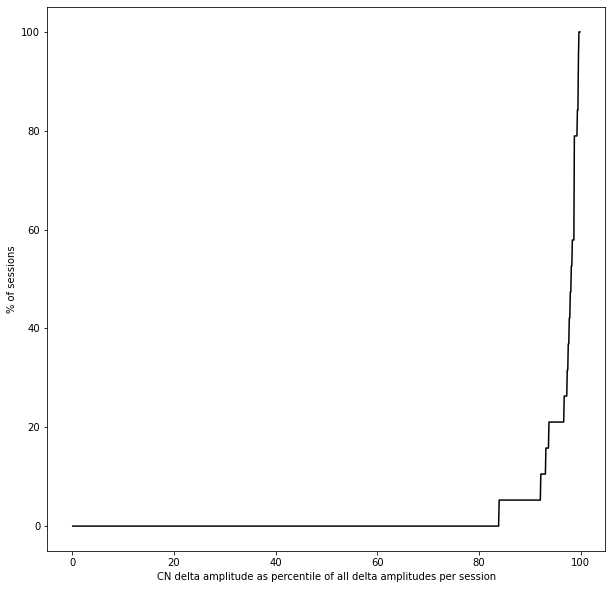

In [210]:
# look at the percentiles
percentiles = []
  
for t0,t1,c0,c1 in zip(yesterday_tuning_all,today_tuning_all,yesterday_tuning_all_cn,today_tuning_all_cn):
    percentiles.append(1-np.argmax(c1-c0>np.sort(t1-t0)[::-1])/len(t0))
y,x = np.histogram(percentiles,np.arange(0,1,.001))
x = np.nanmean([x[1:],x[:-1]],0)*100
fig = plt.figure(figsize = [10,10])
ax1 = fig.add_subplot(1,1,1)
ax1.plot(x,np.cumsum(y)/sum(y)*100,'k-')
ax1.set_ylabel('% of sessions')
ax1.set_xlabel('CN delta amplitude as percentile of all delta amplitudes per session')

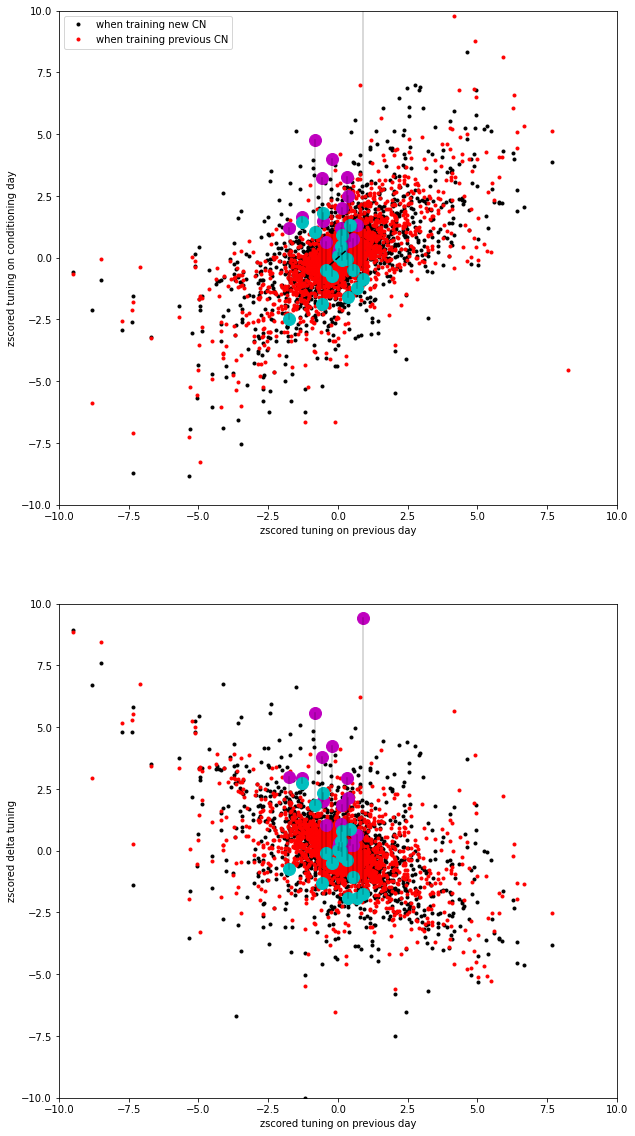

In [211]:
if use_zscored:
    lims = [-10,10]
else:
    lims = [-.8,.8]

fig = plt.figure(figsize = [10,20])
ax = fig.add_subplot(2,1,1)

ax.plot(np.concatenate(yesterday_tuning_all),np.concatenate(today_tuning_all),'k.',alpha = 1,label = 'when training new CN')
ax.plot(np.concatenate(yesterday_tuning_all),np.concatenate(pretask_tuning_all),'r.',alpha = 1,label = 'when training previous CN')
ax.plot(yesterday_tuning_all_cn,today_tuning_all_cn,'mo',alpha = 1,markersize  =12)
ax.plot(yesterday_tuning_all_cn,pretask_tuning_all_cn,'co',alpha = 1,markersize  =12)
for y,t1,t2 in zip(yesterday_tuning_all_cn,today_tuning_all_cn,pretask_tuning_all_cn):
    ax.plot([y,y],[t1,t2],'k-',alpha =.2)
ax.plot([-.3,.3],[-.3,.3],'k--')

ax.set_xlim(lims)
ax.set_ylim(lims)
if use_zscored:
    ax.set_xlabel('zscored tuning on previous day')
    ax.set_ylabel('zscored tuning on conditioning day')
else:
    ax.set_xlabel('tuning on previous day')
    ax.set_ylabel('tuning on conditioning day')

ax.legend()
ax2 = fig.add_subplot(2,1,2)
ax2.plot(np.concatenate(yesterday_tuning_all),np.concatenate(today_tuning_all)-np.concatenate(yesterday_tuning_all),'k.',alpha = 1)
ax2.plot(np.concatenate(yesterday_tuning_all),np.concatenate(pretask_tuning_all)-np.concatenate(yesterday_tuning_all),'r.',alpha = 1)
ax2.plot(yesterday_tuning_all_cn,np.asarray(today_tuning_all_cn)-np.asarray(yesterday_tuning_all_cn),'mo',alpha = 1,markersize  =12)
ax2.plot(yesterday_tuning_all_cn,np.asarray(pretask_tuning_all_cn)-np.asarray(yesterday_tuning_all_cn),'co',alpha = 1,markersize  =12)
for y,t1,t2 in zip(yesterday_tuning_all_cn,np.asarray(today_tuning_all_cn)-np.asarray(yesterday_tuning_all_cn),np.asarray(pretask_tuning_all_cn)-np.asarray(yesterday_tuning_all_cn)):
    ax2.plot([y,y],[t1,t2],'k-',alpha = .2)
ax2.set_xlim(lims)
ax2.set_ylim(lims)
if use_zscored:
    ax2.set_xlabel('zscored tuning on previous day')
else:
    ax2.set_xlabel('tuning on previous day')
if use_zscored:
    ax2.set_ylabel('zscored delta tuning')
else:
    ax2.set_ylabel('delta tuning')

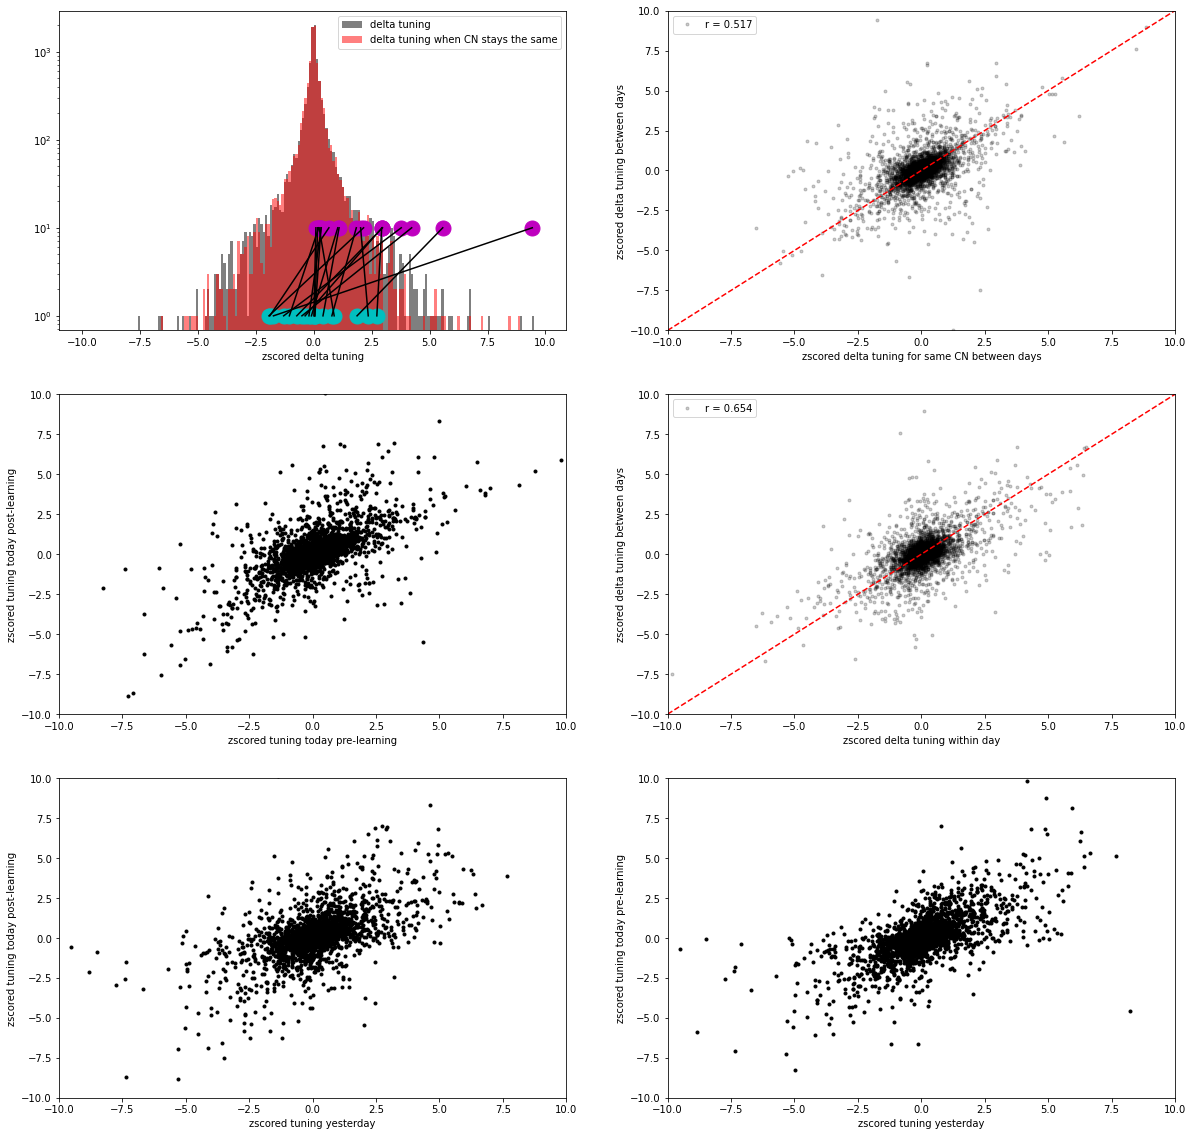

In [212]:
import scipy

if use_zscored:
    histlims = np.arange(-10,10,.1)
else:
    histlims = np.arange(-.8,.8,.01)

fig = plt.figure(figsize = [20,20])
ax1 = fig.add_subplot(3,2,1)
ax1.hist(np.concatenate(today_tuning_all)-np.concatenate(yesterday_tuning_all),histlims,alpha = .5,color = 'black',label = 'delta tuning')
ax1.hist(np.concatenate(pretask_tuning_all)-np.concatenate(yesterday_tuning_all),histlims,alpha = .5,color = 'red',label = 'delta tuning when CN stays the same')
mvals = np.asarray(today_tuning_all_cn)-np.asarray(yesterday_tuning_all_cn)
ax1.plot(mvals,np.ones(len(mvals))*10,'mo',markersize = 15)
cvals = np.asarray(pretask_tuning_all_cn)-np.asarray(yesterday_tuning_all_cn)
ax1.plot(cvals,np.ones(len(cvals)),'co',markersize = 15)
for mval,cval in zip(mvals,cvals):
    ax1.plot([mval,cval],[10,1],'k-')
ax1.set_yscale('log')
ax1.legend()
if use_zscored:
    ax1.set_xlabel('zscored delta tuning')
else:
    ax1.set_xlabel('delta tuning')
ax2 = fig.add_subplot(3,2,4)
x =np.concatenate(today_tuning_all)-np.concatenate(pretask_tuning_all)
y = np.concatenate(today_tuning_all)-np.concatenate(yesterday_tuning_all)
pearsons_test, pearsons_test_p = scipy.stats.pearsonr(x,y)

ax2.plot(x,y,'k.',alpha = .2,label = 'r = {}'.format(np.round(pearsons_test,3)))

ax2.plot(lims,lims,'r--')
ax2.set_xlim(lims)
ax2.set_ylim(lims)
if use_zscored:
    ax2.set_xlabel('zscored delta tuning within day')
    ax2.set_ylabel('zscored delta tuning between days')
else:
    ax2.set_xlabel('delta tuning within day')
    ax2.set_ylabel('delta tuning between days')
ax2.legend()

ax3 = fig.add_subplot(3,2,2)
         
x =np.concatenate(pretask_tuning_all)-np.concatenate(yesterday_tuning_all)
y = np.concatenate(today_tuning_all)-np.concatenate(yesterday_tuning_all)
pearsons_test, pearsons_test_p = scipy.stats.pearsonr(x,y)

ax3.plot(x,y,'k.',alpha = .2,label = 'r = {}'.format(np.round(pearsons_test,3)))
ax3.plot(lims,lims,'r--')
ax3.set_xlim(lims)
ax3.set_ylim(lims)
if use_zscored:
    ax3.set_xlabel('zscored delta tuning for same CN between days')
    ax3.set_ylabel('zscored delta tuning between days')
else:
    ax3.set_xlabel('delta tuning for same CN between days')
    ax3.set_ylabel('delta tuning between days')
ax3.legend()


x =np.concatenate(pretask_tuning_all)
y = np.concatenate(today_tuning_all)
pearsons_test, pearsons_test_p = scipy.stats.pearsonr(x,y)
ax4 = fig.add_subplot(3,2,3)
ax4.plot(x,y,'k.')
ax4.set_xlim(lims)
ax4.set_ylim(lims)
if use_zscored:
    ax4.set_xlabel('zscored tuning today pre-learning')
    ax4.set_ylabel('zscored tuning today post-learning')
else:
    ax4.set_xlabel('tuning today pre-learning')
    ax4.set_ylabel('tuning today post-learning')

x =np.concatenate(yesterday_tuning_all)
y = np.concatenate(today_tuning_all)
pearsons_test, pearsons_test_p = scipy.stats.pearsonr(x,y)
ax4 = fig.add_subplot(3,2,5)
ax4.plot(x,y,'k.')
ax4.set_xlim(lims)
ax4.set_ylim(lims)
if use_zscored:
    ax4.set_xlabel('zscored tuning yesterday')
    ax4.set_ylabel('zscored tuning today post-learning')
else:
    ax4.set_xlabel('tuning yesterday')
    ax4.set_ylabel('tuning today post-learning')
x =np.concatenate(yesterday_tuning_all)
y = np.concatenate(pretask_tuning_all)
pearsons_test, pearsons_test_p = scipy.stats.pearsonr(x,y)
ax4 = fig.add_subplot(3,2,6)
ax4.plot(x,y,'k.')
ax4.set_xlim(lims)
ax4.set_ylim(lims)
if use_zscored:
    ax4.set_xlabel('zscored tuning yesterday')
    ax4.set_ylabel('zscored tuning today pre-learning')
else:
    ax4.set_xlabel('tuning yesterday')
    ax4.set_ylabel('tuning today pre-learning')

(array([7., 3., 2., 4., 1., 1., 0., 0., 0., 1.]),
 array([0.09227489, 1.02622951, 1.96018414, 2.89413876, 3.82809338,
        4.76204801, 5.69600263, 6.62995725, 7.56391187, 8.4978665 ,
        9.43182112]),
 <BarContainer object of 10 artists>)

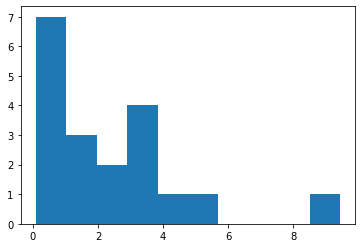

In [213]:
plt.hist(mvals)